In [14]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [15]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [16]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [17]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
input_shape = X_train_scaled.shape[1]

full_input = keras.Input(shape=(input_shape,), name='full_input')
x = layers.Dense(128, activation='relu', name='layer1_Dense128')(full_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer2_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', name='layer3_Dense512')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer4_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='layer5_Dense128')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1, name='logM_star')(x)

model = keras.Model(inputs=full_input, outputs=output, name='SpecPhoto_Model_v1.0')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "SpecPhoto_Model_v1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 full_input (InputLayer)     [(None, 58)]              0         
                                                                 
 layer1_Dense128 (Dense)     (None, 128)               7552      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 layer2_Dense256 (Dense)     (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 layer3_Dense512 (Dense)     (None, 512)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 512)      

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
6093/6093 [==============================] - 25s 4ms/step - loss: 4740614.0000 - mae: 407.5859 - mse: 4740614.0000 - mape: 1311.0740 - val_loss: 1844095.0000 - val_mae: 212.8766 - val_mse: 1844095.0000 - val_mape: 512.7556
Epoch 2/10
6093/6093 [==============================] - 23s 4ms/step - loss: 1181013.5000 - mae: 255.2750 - mse: 1181013.5000 - mape: 623.9605 - val_loss: 650182.6250 - val_mae: 146.4272 - val_mse: 650182.6250 - val_mape: 417.7860
Epoch 3/10
6093/6093 [==============================] - 23s 4ms/step - loss: 871222.5625 - mae: 213.1587 - mse: 871222.5625 - mape: 505.0002 - val_loss: 1251581.7500 - val_mae: 126.7124 - val_mse: 1251581.7500 - val_mape: 525.2036
Epoch 4/10
6093/6093 [==============================] - 23s 4ms/step - loss: 669652.9375 - mae: 190.8505 - mse: 669652.9375 - mape: 454.6700 - val_loss: 454454.8125 - val_mae: 147.3922 - val_mse: 454454.8125 - val_mape: 522.1927
Epoch 5/10
6093/6093 [==============================] - 23s 4ms/step - loss

In [22]:
# Save weights from the trained model
model.save_weights('models/spec_photo_model_v1.0.h5')

In [23]:
y_pred_full = model.predict(X_test_scaled)

# Evaluate accuracy metrics
mae = mean_absolute_error(y_test, y_pred_full)
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"Spectrometry and Photometry Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

1904/1904 [==============================] - 2s 1ms/step
Spectrometry and Photometry Model Evaluation:
Mean Absolute Error (MAE): 80.9286
Root Mean Squared Error (RMSE): 539.4174
R² Score: 0.9666


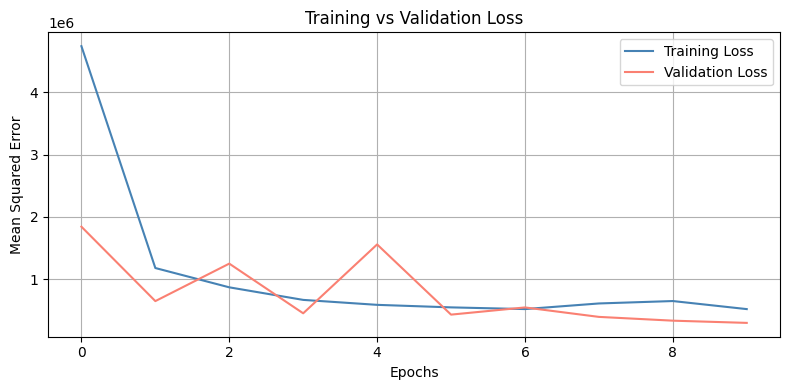

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

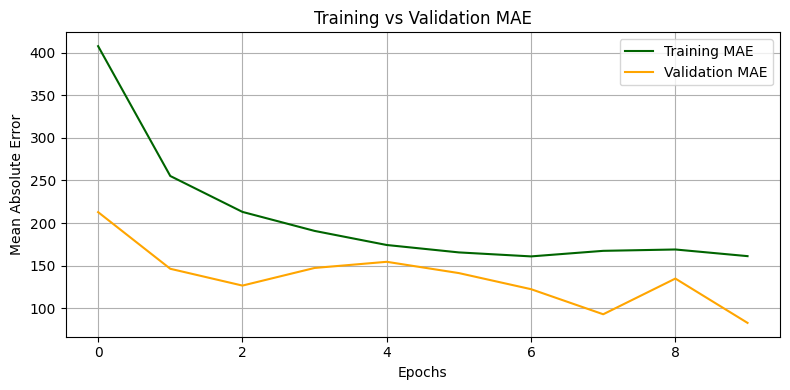

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()